In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv', keep_default_na=False) #Reading the dataset

#Normal and Normal Weight are the same thing, so we will replace Normal Weight with Normal
data['BMI Category'] = data['BMI Category'].replace('Normal Weight', 'Normal')

#We will categorize the blood pressure into three categories: Normal, Prehypertension and Hypertension
def categorize_bp(row):
    systolic, diastolic = map(int, row['Blood Pressure'].split('/'))
    if systolic >= 140 or diastolic >= 90:
        return 'Hypertension'
    elif 120 <= systolic < 140 or 80 <= diastolic < 90:
        return 'Prehypertension'
    else:
        return 'Normal'

data['Blood Pressure'] = data.apply(categorize_bp, axis=1)

#Convert the data into numerical values
categories = ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']

# Create a dictionary to store LabelEncoders for each category
label_encoders = {}

for category in categories:
    LE = LabelEncoder()
    data[category] = LE.fit_transform(data[category])
    label_encoders[category] = LE

#Drop the Person ID column
data.drop('Person ID', axis=1, inplace=True)

#Get encoded data information
encoders_info = {col: dict(zip(LE.classes_, LE.transform(LE.classes_))) for col, LE in label_encoders.items()}
print(encoders_info)

{'Gender': {'Female': 0, 'Male': 1}, 'Occupation': {'Accountant': 0, 'Doctor': 1, 'Engineer': 2, 'Lawyer': 3, 'Manager': 4, 'Nurse': 5, 'Sales Representative': 6, 'Salesperson': 7, 'Scientist': 8, 'Software Engineer': 9, 'Teacher': 10}, 'BMI Category': {'Normal': 0, 'Obese': 1, 'Overweight': 2}, 'Blood Pressure': {'Hypertension': 0, 'Normal': 1, 'Prehypertension': 2}, 'Sleep Disorder': {'Insomnia': 0, 'None': 1, 'Sleep Apnea': 2}}


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Define the features and target variable
x = data.drop('Quality of Sleep', axis=1)
y = data['Quality of Sleep']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32, shuffle=True)

print("Training set size:", x_train.shape)
print("Testing set size:", x_test.shape)

print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

Training set size: (261, 11)
Testing set size: (113, 11)
y train shape: (261,)
y test shape: (113,)


In [2]:
#Create a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

#Define the hyperparameters
param_grid = [
    {'classifier': [RandomForestClassifier()],
     'classifier__n_estimators': [50, 100, 200],
     'classifier__max_depth': [None, 5, 10, 15],
     'classifier__min_samples_split': [2, 5, 10],
     'classifier__min_samples_leaf': [1, 2, 5],
     'classifier__max_features': ['sqrt', 'log2']},
    {'classifier': [GradientBoostingClassifier()],
     'classifier__n_estimators': [50, 100, 200],
     'classifier__learning_rate': [0.1, 0.01, 0.001],
     'classifier__max_features': ['sqrt', 'log2']},
    {'classifier': [SVC()],
     'classifier__C': [0.1, 1, 10, 100],
     'classifier__gamma': [1, 0.1, 0.01, 0.001],
     'classifier__kernel': ['linear', 'rbf']},
    {'classifier': [LogisticRegression()],
     'classifier__C': [0.1, 1, 10, 100],
     'classifier__solver': ['lbfgs', 'liblinear']},
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': [3, 5, 7, 9],
     'classifier__weights': ['uniform', 'distance'],
     'classifier__algorithm': ['ball_tree', 'kd_tree', 'brute']},
    {'classifier': [DecisionTreeClassifier()],
     'classifier__criterion': ['gini', 'entropy'],
     'classifier__splitter': ['best', 'random'],
     'classifier__max_depth': [None, 5, 10, 15]}
]

# Grid search
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(x_train, y_train)

#Get the best model
best_model = grid.best_estimator_

#Get the accuracy of each model
accuracy_scores = []
models = ['RandomForestClassifier', 'GradientBoostingClassifier', 'SVC', 'LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier']
for model in models:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', eval(model + '()'))
    ])
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

NameError: name 'Pipeline' is not defined

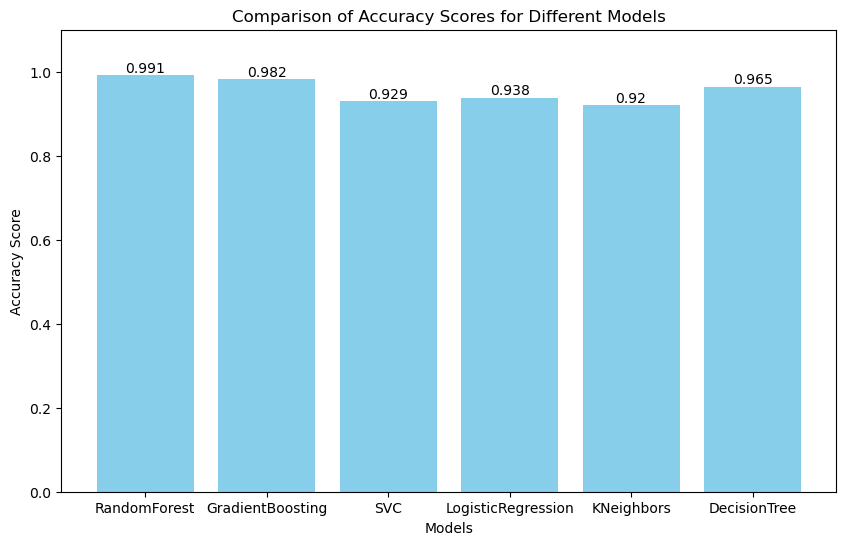

In [5]:
import matplotlib.pyplot as plt

# Define the models
models = ['RandomForest', 'GradientBoosting', 'SVC', 'LogisticRegression', 'KNeighbors', 'DecisionTree']

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracy_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Accuracy Scores for Different Models')
plt.ylim(0, 1.1)

# Add accuracy values on top of each bar
for bar, score in zip(bars, accuracy_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(score, 3), ha='center', va='bottom')

plt.show()

It shows that GradientBoosting and DecisionTree is overfitting as it has accruacy of 100%.


In [1]:
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]
features = x.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(x.shape[1]), importances[indices], align="center")
plt.xticks(range(x.shape[1]), features[indices], rotation=45)
plt.xlim([-1, x.shape[1]])
plt.show()

NameError: name 'best_model' is not defined

In [7]:
import joblib

# Print the best performing model and its hyperparameters
print("\nBest Performing Model:")
for param, value in grid.best_params_.items():
    print(f"{param}: {value}")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')


Best Performing Model:
classifier: RandomForestClassifier()
classifier__max_depth: 15
classifier__max_features: sqrt
classifier__min_samples_leaf: 1
classifier__min_samples_split: 5
classifier__n_estimators: 100


['best_model.pkl']

In [9]:
import os

# Create a folder to save the graphs
folder_name = 'graphs'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Save the accuracy scores plot
plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracy_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Accuracy Scores for Different Models')
plt.ylim(0, 1.1)
for bar, score in zip(bars, accuracy_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(score, 3), ha='center', va='bottom')
plt.savefig(os.path.join(folder_name, 'accuracy_scores.png'))
plt.close()

# Save the feature importances plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(x.shape[1]), importances[indices], align="center")
plt.xticks(range(x.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x.shape[1]])
plt.savefig(os.path.join(folder_name, 'feature_importances.png'))
plt.close()